Deep Convolutional GAN with Fashion MNIST
===



# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# @title Utility function to render image
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    """
    Displays n of the given image arrays.
    """
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    plt.show()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Parameters

In [ ]:
IMAGE_SIZE = 28
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 100
EPOCHS = 20
LEARNING_RATE = 0.0005

# Training Data

In [ ]:
# @title Load
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
# @title Conform tf.data.Dataset
%%time

# Create TensorFlow datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# normalization for batch data
def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.expand_dims(image, -1)
    # image = tf.pad(image, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    image = image * 2.0 - 1.0
    print(image.shape)
    return image, label

# Apply normalization and batch the datasets
train_dataset_normalized = train_dataset.prefetch(
    tf.data.AUTOTUNE).shuffle(buffer_size=1024).batch(
        BATCH_SIZE).map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_normalized = test_dataset.batch(BATCH_SIZE).map(normalize)

Cause: Unable to locate the source code of <function normalize at 0x7cb1db061fc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function normalize at 0x7cb1db061fc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(None, 28, 28, 1)
(None, 28, 28, 1)
CPU times: user 93.3 ms, sys: 58.8 ms, total: 152 ms
Wall time: 153 ms


(128, 28, 28, 1)


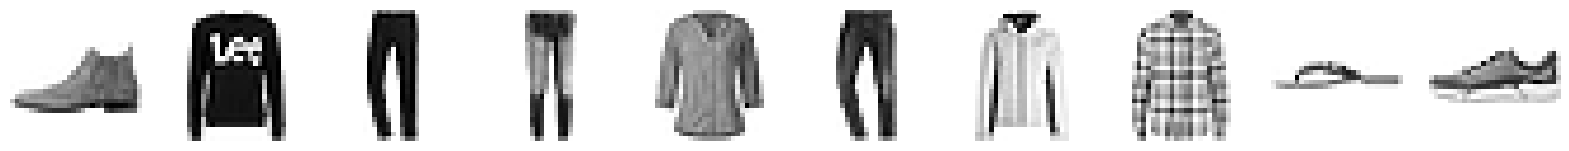

In [ ]:
def display_dataset(dataset):
    for image, label in dataset.take(1):
        print(image.shape)
        plt.figure(figsize=(20,3))
        n = 10

        for i in range(n):
            _ = plt.subplot(1, n, i + 1)
            plt.imshow(image[i].numpy(), cmap='gray_r')
            plt.axis("off")
display_dataset(test_dataset_normalized)

# Construct Deep Convolutional GAN

In [ ]:
# @title Generator
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[EMBEDDING_DIM, ]),
    keras.layers.Reshape([7, 7, 128]), # 7 x 7 x 128
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, # 14 x 14 x 64
                                 padding='same', activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, # 28 x 28 x 1
                                 padding='same',
                                 activation='tanh', # scale to [-1, +1] to make images
                                 ),
])
print(generator.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 64)        204864    
 Transpose)                                                      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                      

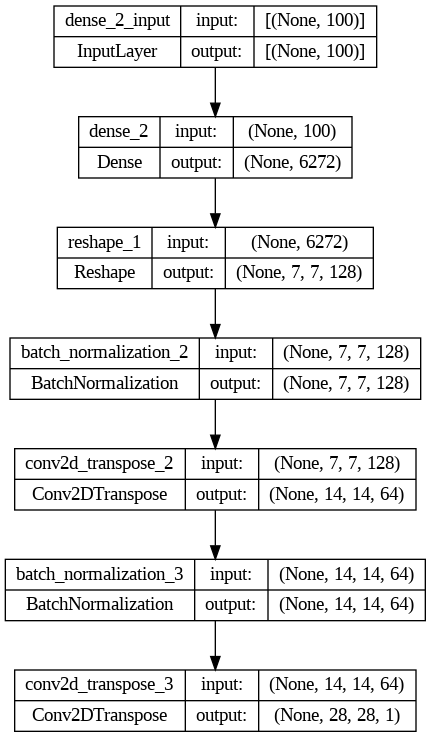

In [ ]:
tf.keras.utils.plot_model(model=generator, show_shapes=True, show_layer_names=True)

In [ ]:
# @title Discriminator
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, # 14 x 14 x 64
                        padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=5, strides=2, # 7 x 7 x 128
                        padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid'),
])
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

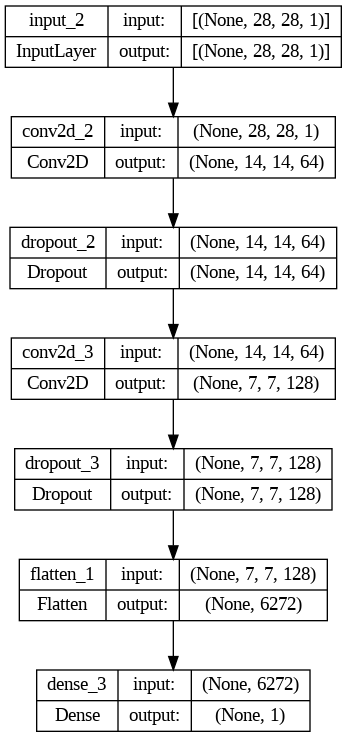

In [ ]:
tf.keras.utils.plot_model(model=discriminator, show_shapes=True, show_layer_names=True)

In [ ]:
# @title GAN
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 1053186 (4.02 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [ ]:
# @title Compile

# compile discriminator
discriminator.compile(loss='binary_crossentropy', # predict 0 or 1
                      optimizer='rmsprop', metrics=['accuracy'])

# compile GAN ( generator )
discriminator.trainable = False # freeze the weight of discriminator during training GAN
gan.compile(
    # train GAN with the predictions of discriminator
    loss='binary_crossentropy',
    # TODO It is better to set smaller learning rate than discriminator
    # because we want to strengthen the discriminator more
    optimizer='rmsprop')

In [ ]:
# @title Custom loop of GAN

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        for X_batch, label in dataset:
            # phase 1 - train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # create noise BATCH_SIZE x CODING_SIZE
            generated_images = generator(noise) # generate fake images

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # concat fake / genuine images with same number
            y1 = tf.constant([[0.]] * len(generated_images) + [[1.]] * len(X_batch)) # concat the labels, 0: fake, 1: genuine
            discriminator.trainable = True # make trainable of discriminator
            discriminator.train_on_batch(X_fake_and_real, y1) # train discriminator with a batch

            # phase 2 - train generator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # create noise BATCH_SIZE x CODING_SIZE
            y2 = tf.constant([[1.]] * batch_size) # train generator with labels 1 to expect discriminator to predict 1
            discriminator.trainable = False # freeeze the weight of discriminator during training generator
            gan.train_on_batch(noise, y2) # train generator with a batch
        plot_multiple_images(generated_images, 8)
        plt.show()

In [ ]:
# @title Train
train_gan(gan, train_dataset_normalized, batch_size=BATCH_SIZE, codings_size=EMBEDDING_DIM, n_epochs=EPOCHS)

Output hidden; open in https://colab.research.google.com to view.